In [1]:
import re
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

results_dir = Path("results")

In [2]:
SYSTEM_SIDE = 4
ATOL_H = 1e-6

TARGET_SEEDS = {42, 43, 44, 45, 46, 47, 48, 49, 50, 51}

SAMPLE_SIZES = [2_000, 5_000, 20_000]

In [4]:
all_files = list(results_dir.glob(f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_sample_eff_rbm_seed*_*.csv"))
parsed = []

for p in all_files:
    s_match = re.search(r"seed(\d+)", p.name)
    t_match = re.search(r"(\d{8}_\d{6})", p.name)
    if s_match and t_match:
        parsed.append({"seed": int(s_match.group(1)), "ts": t_match.group(1), "path": p})

parsed.sort(key=lambda x: x["ts"], reverse=True)

selected_map = {}
for item in parsed:
    s = item["seed"]
    if s in TARGET_SEEDS and s not in selected_map:
        selected_map[s] = item["path"]

selected_paths = [selected_map[s] for s in sorted(selected_map.keys())]
SEEDS = sorted(selected_map.keys())

print(
    f"Found {len(selected_paths)} sample-efficiency result files overlapping with specified seed set (newest match only):")
for p in selected_paths:
    print(f"  - {p.name}")

Found 3 sample-efficiency result files overlapping with specified seed set (newest match only):
  - tfim_4x4_sample_eff_rbm_seed42_20260208_015434.csv
  - tfim_4x4_sample_eff_rbm_seed43_20260208_015428.csv
  - tfim_4x4_sample_eff_rbm_seed44_20260208_015432.csv


In [5]:
dfs = [pd.read_csv(p) for p in selected_paths]
all_results_df = pd.concat(dfs, ignore_index=True)

expected_cols = {"seed", "n_samples", "h", "type", "overlap"}
missing = expected_cols - set(all_results_df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {sorted(missing)}")

all_results_df = all_results_df[list(expected_cols)].copy()
all_results_df["seed"] = all_results_df["seed"].astype(int)
all_results_df["n_samples"] = all_results_df["n_samples"].astype(int)
all_results_df["h"] = all_results_df["h"].astype(float)
all_results_df["type"] = all_results_df["type"].astype(str)
all_results_df["overlap"] = all_results_df["overlap"].astype(float)

print(f"Loaded rows: {len(all_results_df):,}")
print(f"Sample sizes found: {sorted(all_results_df['n_samples'].unique())}")

Loaded rows: 126
Sample sizes found: [2000, 5000, 20000]


In [9]:
agg_df = (
    all_results_df
    .groupby(["n_samples", "type", "h"], as_index=False, observed=True)
    .agg(
        overlap=("overlap", "median"),
        overlap_err=("overlap", lambda x: x.std(ddof=0)),
        n=("overlap", "count"),
    )
    .sort_values(["n_samples", "type", "h"])
)

agg_df.head()

,n_samples,type,h,overlap,overlap_err,n
0,2000,novel,1.5,0.997817,0.000266,3
1,2000,novel,2.5,0.981484,0.003003,3
2,2000,novel,2.8,0.975803,0.002394,3
3,2000,novel,3.2,0.977048,0.001812,3
4,2000,novel,3.5,0.979978,0.001932,3


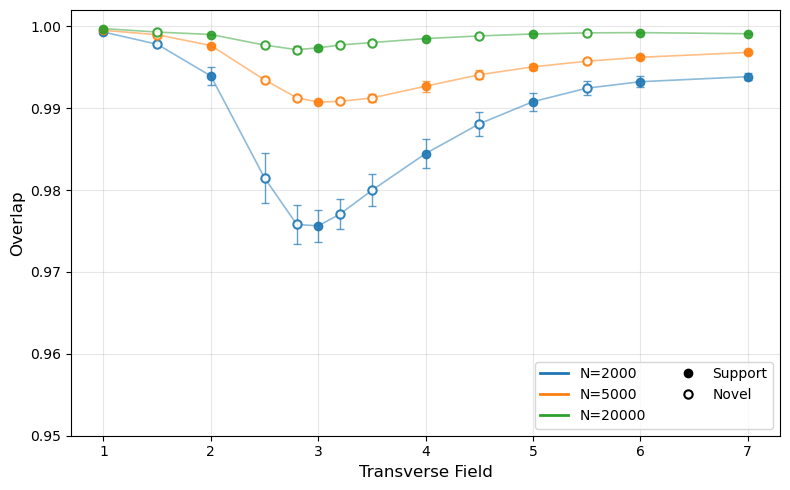

In [10]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

cmap = plt.get_cmap("tab10")
color_map = {n: cmap(i) for i, n in enumerate(SAMPLE_SIZES)}

LINE_KW = dict(lw=1.2, alpha=0.5, zorder=5)
MARKER_KW = dict(markersize=6, alpha=0.9, zorder=6)

ERR_KW = dict(capsize=3, elinewidth=1.0, alpha=0.7)

for n_samples in SAMPLE_SIZES:
    sub = agg_df.query("n_samples == @n_samples").sort_values("h")
    c = color_map[n_samples]

    ax.plot(sub["h"], sub["overlap"], "-", color=c, **LINE_KW)

    supp = sub.query("type == 'support'")
    ax.errorbar(supp["h"], supp["overlap"], yerr=supp["overlap_err"], fmt="none", ecolor=c,
                zorder=MARKER_KW["zorder"] - 1, **ERR_KW)
    ax.plot(supp["h"], supp["overlap"], "o", color=c, **MARKER_KW)

    # novel markers + error bars (white face)
    nov = sub.query("type == 'novel'")
    ax.errorbar(nov["h"], nov["overlap"], yerr=nov["overlap_err"], fmt="none",
                ecolor=c, zorder=MARKER_KW["zorder"] - 1, **ERR_KW)
    ax.plot(nov["h"], nov["overlap"], "o", color=c,
            markerfacecolor="white", markeredgewidth=1.5, **MARKER_KW)

sample_handles = [Line2D([0], [0], color=color_map[n], lw=2, label=f"N={n}") for n in SAMPLE_SIZES]
marker_handles = [
    Line2D([0], [0], color="black", marker="o", linestyle="", label="Support"),
    Line2D([0], [0], color="black", marker="o", markerfacecolor="white",
           markeredgewidth=1.5, linestyle="", label="Novel"),
]

ax.legend(handles=sample_handles + marker_handles, loc="lower right", ncol=2)

ax.set_xlabel(r"Transverse Field", fontsize=12)
ax.set_ylabel(r"Overlap", fontsize=12)

ax.set_ylim(0.95, 1.002)
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = results_dir / f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_sample_eff_rbm_err_{timestamp}.csv"

out_df = agg_df[["n_samples", "type", "h", "overlap", "overlap_err", "n"]].copy()
out_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Saved: {save_path}")

Saved: results/tfim_4x4_sample_eff_rbm_err_20260208_021547.csv
